In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from scipy.optimize import linear_sum_assignment

In [2]:
class GatingAttentionUnit (nn.Module) :
  def __init__ (self,embed_dim) :
    super().__init__()
    self.lq = nn.Linear(embed_dim,embed_dim,bias=False)
    self.lk = nn.Linear(embed_dim,embed_dim,bias=False)
    self.lv = nn.Linear(embed_dim,embed_dim,bias=False)
    self.lgate = nn.Linear(embed_dim,embed_dim)
    self.lo = nn.Linear(embed_dim,embed_dim)

  def __countAttention (self,Q,K,V) :
    score = torch.matmul(Q,K.transpose(-2,-1)) / K.shape[-1] ** 0.5
    attention = F.softplus(score)
    output = torch.matmul(attention,V)
    return output

  def forward(self,Q,K,V) :
    q = self.lq(Q)
    k = self.lk(K)
    v = self.lv(V)
    attention = self.__countAttention(q,k,v)
    gate = self.lgate(Q)
    gate = F.sigmoid(gate)
    output = attention * gate
    output = self.lo(output)
    return output

class MultiQueryAttention (nn.Module) :
  def __init__ (self,embed_dim,num_queary) :
    super().__init__()
    self.query_dim = embed_dim // num_queary
    self.num_q = num_queary
    self.lq = nn.Linear(embed_dim,embed_dim,bias=False)
    self.lk = nn.Linear(embed_dim,self.query_dim,bias=False)
    self.lv = nn.Linear(embed_dim,self.query_dim,bias=False)
    self.lo = nn.Linear(embed_dim,embed_dim)

  def __split_heads(self,x : torch.Tensor) :
    b,s,d = x.shape
    x = x.reshape(b,s,self.num_q,self.query_dim)
    return x.transpose(1,2)

  def __scaled_dot_product(self,Q,K,V) :
    score = torch.matmul(Q,K.transpose(-2,-1)) / K.shape[-1] ** 0.5
    attention = F.softmax(score,dim=-1)
    output = torch.matmul(attention,V)
    return output

  def forward (self,Q,K,V) :
    b,s,d = Q.shape
    q = self.__split_heads(self.lq(Q))
    k = self.lk(K)
    k = torch.unsqueeze(k,dim=1)
    v = self.lv(V)
    v = torch.unsqueeze(v,dim=1)

    attn = self.__scaled_dot_product(q,k,v)
    attn = torch.permute(attn,(0,2,1,3))
    attn = torch.reshape(attn,(b,s,d))
    out = self.lo(attn)

    return out

class ReZero (nn.Module) :
  def __init__(self):
    super().__init__()
    self.alpha = nn.Parameter(torch.zeros(size=(1,)))

  def forward(self,x,factor) :
    return x + self.alpha * factor

class ScaleNorm (nn.Module) :
  def __init__(self,embed_dim,epsilon=1e-5) :
    super().__init__()
    self.gamma = nn.Parameter(torch.ones(size=(embed_dim,)))
    self.eps = epsilon

  def forward (self,x) :
    sum_val = torch.sum(x ** 2,dim=-1,keepdim=True)
    norm = torch.sqrt(sum_val) + self.eps
    return (x / norm) * self.gamma

class LCM (nn.Module) :
  def __init__ (self,embed_dim,drop_rate) :
    super().__init__()
    self.norm = ScaleNorm(embed_dim)
    self.dropout = nn.Dropout(p=drop_rate)
    self.step1 = nn.Linear(embed_dim,embed_dim)
    self.step2 = nn.Linear(embed_dim,embed_dim)
    self.magnitude = nn.Linear(embed_dim,embed_dim)
    self.rezero = ReZero()


  def forward(self,x) :
    z = self.norm(x)
    step1 = self.step1(z)
    step1 = F.gelu(step1,approximate='tanh')
    step2 = self.step2(z)
    step2 = F.gelu(step2,approximate='tanh')
    latent = step1 + step2
    latent = self.dropout(latent)
    latent = self.magnitude(latent)
    latent = F.tanh(latent)
    return self.rezero(x,latent)

class SiGLU (nn.Module) :
  def __init__ (self,embed_dim,hidden_state) :
    super().__init__()
    self.l1 = nn.Linear(embed_dim,hidden_state)
    self.l2 = nn.Linear(embed_dim,hidden_state)
    self.l3 = nn.Linear(hidden_state,embed_dim)

  def forward (self,x) :
    x1 = self.l1(x)
    x2 = self.l2(x)
    x = x1 * F.silu(x2)
    x = self.l3(x)
    return x

In [3]:
class PatchEmbedding (nn.Module) :
  def __init__ (self,image_size,num_patch,embed_dim) :
    super().__init__()
    self.projection = nn.Conv2d(3,embed_dim,kernel_size=num_patch,stride=num_patch)
    self.n_path = (image_size//num_patch)**2

  def forward (self,x) :
    x = self.projection(x)
    x = x.flatten(2)
    x = x.transpose(1,2)
    return x

class PositionalEncoding (nn.Module) :
  def __init__ (self,embed_dim,n_path) :
    super().__init__()
    self.poslearn = nn.Parameter(data=torch.normal(mean=0,std=0.02,size=(1,n_path,embed_dim)))

  def forward (self,x) :
    return x+self.poslearn

class VITBlock (nn.Module) :
  def __init__ (self,embed_dim,drop_rate) :
    super().__init__()
    self.norm = ScaleNorm(embed_dim)
    self.dropout = nn.Dropout(p=drop_rate)
    self.attention = GatingAttentionUnit(embed_dim)
    self.lcm = LCM(embed_dim,drop_rate)
    self.rezero = ReZero()

  def forward(self,x) :
    znorm = self.norm(x)
    attn = self.attention(znorm,znorm,znorm)
    attn = self.dropout(attn)
    x = self.rezero(x,attn)

    x = self.lcm(x)
    return x

class DecoderBlock(nn.Module) :
  def __init__(self,embed_dim,drop_rate) :
    super().__init__()
    self.norm1 = nn.RMSNorm(embed_dim)
    self.norm2 = nn.RMSNorm(embed_dim)
    self.norm3 = nn.RMSNorm(embed_dim)
    self.attention = MultiQueryAttention(embed_dim,num_queary=4)
    self.siglu = SiGLU(embed_dim=embed_dim,hidden_state=embed_dim * 2)
    self.crossAttention = MultiQueryAttention(embed_dim,num_queary=4)
    self.dropou1 = nn.Dropout(p=drop_rate)
    self.dropou2 = nn.Dropout(p=drop_rate)
    self.dropou3 = nn.Dropout(p=drop_rate)

  def forward(self,logits,factor) :
    lnorm = self.norm1(logits)
    attn = self.attention(lnorm,lnorm,lnorm)
    attn =self.dropou1(attn)
    logits = logits + attn

    lnorm = self.norm2(logits)
    attn = self.crossAttention(lnorm,factor,factor)
    attn = self.dropou2(attn)
    logits = logits + attn

    lnorm = self.norm3(logits)
    siglu = self.siglu(lnorm)
    siglu = self.dropou3(siglu)
    logits = logits + siglu
    return logits

In [4]:
class VIT (nn.Module) :
  def __init__ (self,image_size,patch_size,embed_dim) :
    super().__init__()
    self.patchembedding = PatchEmbedding(image_size,num_patch=patch_size,embed_dim = embed_dim)
    self.postionalencoder = PositionalEncoding(embed_dim,self.patchembedding.n_path)
    self.Transformersblock = nn.ModuleList([VITBlock(embed_dim,drop_rate=0.05) for _ in range(3)])
    self.globalffn = nn.Sequential(
        nn.Linear(embed_dim,embed_dim * 3),
        nn.GELU(),
        nn.Linear(embed_dim * 3,embed_dim)
    )

  def forward(self,x) :
    x = self.patchembedding(x)
    x = self.postionalencoder(x)
    for layer in self.Transformersblock :
      x = layer(x)
    x = self.globalffn(x)
    return x

class Decoder (nn.Module) :
  def __init__(self,embed_dim) :
    super().__init__()
    self.Decoderblock = nn.ModuleList([DecoderBlock(embed_dim,0.1) for _ in range(3)])

  def forward(self,query,memory) :
    for layer in self.Decoderblock :
      query = layer(query,memory)

    return query

class DETR (nn.Module) :
  def __init__(self,
               image_size = 244,embed_dim=512,num_query=100,num_class=1) :
               super().__init__()
               self.backbone = VIT(image_size=image_size,patch_size=16,embed_dim=embed_dim)
               self.object_query = nn.Parameter(torch.randn(size=(num_query,embed_dim)))
               self.decoder = Decoder(embed_dim)
               self.class_head = nn.Linear(embed_dim,num_class + 1)
               self.box_head = nn.Sequential(
                   nn.Linear(embed_dim,embed_dim),
                   nn.ReLU(),
                   nn.Linear(embed_dim,4)
               )

  def forward(self,x) :
    B = x.shape[0]
    memory = self.backbone(x)
    query = self.object_query.unsqueeze(0).repeat(B,1,1)
    query = self.decoder(query,memory)
    class_pred = self.class_head(query)
    box_pred = self.box_head(query).sigmoid()

    return {
        'class_pred' : class_pred,
        'box_pred' : box_pred
    }



In [6]:
def hungarian_matching(logits, boxes, tgt_labels, tgt_boxes):
    """
    logits: (Q, C)
    boxes: (Q, 4)  in cx,cy,w,h normalized
    tgt_labels: (T,)
    tgt_boxes: (T, 4)
    """
    prob = logits.softmax(-1)
    cost_class = -prob[:, tgt_labels]              # (Q, T)
    cost_bbox = torch.cdist(boxes, tgt_boxes, p=1) # (Q, T)

    cost = cost_class + cost_bbox
    cost = cost.detach().cpu()

    row_ind, col_ind = linear_sum_assignment(cost)
    return row_ind, col_ind


def detr_loss(class_pred, box_pred, class_label, box_label, num_classes):
    """
    class_pred: (B, Q, C)
    box_pred:   (B, Q, 4)
    class_label:(B, T)
    box_label:  (B, T, 4)
    """
    loss_cls = 0.
    loss_box = 0.

    B, Q, _ = class_pred.shape
    weight_no_class = torch.ones(num_classes + 1, device=class_pred.device)
    weight_no_class[num_classes] = 0.1

    for b in range(B):
        logits = class_pred[b]
        boxes = box_pred[b]
        labels = class_label[b]
        tgt_boxes = box_label[b]

        idx_q, idx_t = hungarian_matching(
            logits, boxes, labels, tgt_boxes
        )

        target_cls = torch.full(
            (Q,), num_classes, device=logits.device
        )
        target_cls[idx_q] = labels[idx_t]

        loss_cls += F.cross_entropy(logits, target_cls,weight=weight_no_class)
        loss_box += F.l1_loss(boxes[idx_q], tgt_boxes[idx_t])

    return loss_cls + loss_box


In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adilshamim8/people-detection")

print("Path to dataset files:", path)

100%|██████████| 1.94G/1.94G [00:21<00:00, 95.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/adilshamim8/people-detection/versions/1


In [8]:
import pandas as pd


In [9]:
df = pd.read_csv(path+'/train/train/_annotations.csv')
df

,filename,width,height,class,xmin,ymin,xmax,ymax
0,2008_003132_jpg.rf.92f6223defec4f57f2d7b9cfa28...,500,375,person,219,98,269,283
1,2008_003132_jpg.rf.92f6223defec4f57f2d7b9cfa28...,500,375,person,114,124,155,263
2,2008_003132_jpg.rf.92f6223defec4f57f2d7b9cfa28...,500,375,person,43,139,98,340
3,004574_jpg.rf.7c8cea69d7be45f58febcede26ef0c6e...,500,333,person,145,118,229,333
4,004574_jpg.rf.7c8cea69d7be45f58febcede26ef0c6e...,500,333,person,285,105,349,329
...,...,...,...,...,...,...,...,...
100077,2008_007145_jpg.rf.99fc120cdee10b38fe50fe80989...,4410,3308,person,1957,1753,2022,1847
100078,2008_007145_jpg.rf.99fc120cdee10b38fe50fe80989...,4410,3308,person,2014,1753,2099,1854
100079,2008_007145_jpg.rf.99fc120cdee10b38fe50fe80989...,4410,3308,person,1519,1805,1588,1920
100080,2008_007145_jpg.rf.99fc120cdee10b38fe50fe80989...,4410,3308,person,1588,1809,1657,1901


In [11]:
import os
from torch.utils.data import Dataset
from PIL import Image
import torch
from torchvision import transforms as T

class PeopleDetectionDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.df = dataframe
        self.image_dir = image_dir
        self.transform = transform
        self.images = dataframe['filename'].unique().tolist()

    def __getitem__(self, idx):
        filename = self.images[idx]

        img_path = os.path.join(self.image_dir, filename)
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image file {img_path} not found!")

        image = Image.open(img_path).convert("RGB")


        boxes_df = self.df[self.df['filename'] == filename]
        boxes = boxes_df[['xmin', 'ymin', 'xmax', 'ymax']].values
        boxes = torch.tensor(boxes, dtype=torch.float32)


        w = boxes[:, 2] - boxes[:, 0]
        h = boxes[:, 3] - boxes[:, 1]
        x_center = boxes[:, 0] + w / 2
        y_center = boxes[:, 1] + h / 2

        img_w, img_h = image.size
        x_center /= img_w
        y_center /= img_h
        w /= img_w
        h /= img_h

        boxes = torch.stack([x_center, y_center, w, h], dim=1)


        labels = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx])
        }

        if self.transform:
            image = self.transform(image)

        return image, target

    def __len__(self):
        return len(self.images)


In [12]:
transform = T.Compose([
    T.Resize((360, 360)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [13]:
datasets = PeopleDetectionDataset(df,path+'/train/train',transform)

In [14]:
dataloaded = torch.utils.data.DataLoader(datasets,batch_size=32,shuffle=True,collate_fn=lambda x : tuple(zip(*x)))

In [15]:
def pooling_data (target_data) :
  boxes = []
  label = []
  for t in target_data :
    boxes.append(t['boxes'].to('cuda'))
    label.append(t['labels'].to('cuda'))
  return boxes,label

In [20]:
pretrained_model = DETR(image_size=360,embed_dim=384,num_query=100,num_class=1)
optimizer = torch.optim.AdamW(pretrained_model.parameters(),lr=0.0001)
pretrained_model.to('cuda')
pretrained_model.train()




DETR(
  (backbone): VIT(
    (patchembedding): PatchEmbedding(
      (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    )
    (postionalencoder): PositionalEncoding()
    (Transformersblock): ModuleList(
      (0-2): 3 x VITBlock(
        (norm): ScaleNorm()
        (dropout): Dropout(p=0.05, inplace=False)
        (attention): GatingAttentionUnit(
          (lq): Linear(in_features=384, out_features=384, bias=False)
          (lk): Linear(in_features=384, out_features=384, bias=False)
          (lv): Linear(in_features=384, out_features=384, bias=False)
          (lgate): Linear(in_features=384, out_features=384, bias=True)
          (lo): Linear(in_features=384, out_features=384, bias=True)
        )
        (lcm): LCM(
          (norm): ScaleNorm()
          (dropout): Dropout(p=0.05, inplace=False)
          (step1): Linear(in_features=384, out_features=384, bias=True)
          (step2): Linear(in_features=384, out_features=384, bias=True)
          (magnitude)

In [16]:
loss_hits = []
from tqdm import tqdm

In [26]:
epochs = 2
for epoch in range(epochs) :
  loss_total = 0
  iterator = tqdm(dataloaded)
  for image,label in iterator :
    image = torch.stack(image,dim=0).to('cuda')
    label = pooling_data(label)
    predicted = pretrained_model(image)
    loss = detr_loss(predicted['class_pred'],predicted['box_pred'],label[1],label[0],1)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_total += loss.item()
    iterator.set_description(f"epoch {epoch+1}/{epochs} loss : {loss.item()}")

  loss_total /= len(dataloaded)
  loss_hits.append(loss_total)
  print(f"epoch {epoch+1}/{epochs} loss : {loss_total}")

epoch 1/2 loss : 9.4094877243042: 100%|██████████| 415/415 [07:23<00:00,  1.07s/it]


epoch 1/2 loss : 10.068002064256783


epoch 2/2 loss : 9.930267333984375: 100%|██████████| 415/415 [07:28<00:00,  1.08s/it]

epoch 2/2 loss : 9.941144192936909


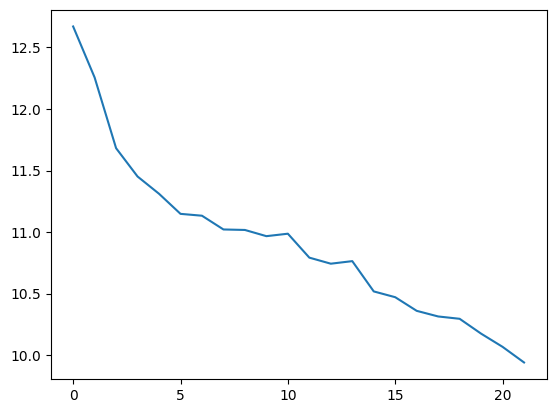

In [27]:
import matplotlib.pyplot as plt
plt.plot(loss_hits)
plt.show()

## Note :  is just experiment, gating Attention units and Multi Query units is  present for NLP model and fokus at spesial token contexts. if you wanna make a real DETR, you can use this note book, but just replace a GAU and MQA to MHA .